# Project N°1 : MCMC for bayesian inference & implementation of an exemple of variance reduction for Monte Carlo  

## Part 1 :

## Simulation of a variance reduction method based on Monte Carlo importance sampling  

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import time
def h(x):
    value=np.exp(-1*x+np.cos(x))   #h(x)=e^(-X+cos(X))
    return(value)


def f(x):
    value=np.exp(-2*x)   #f(x)=e^(-2*X)
    return(value)


def g(x):
    value=np.exp(-1*x)    #g(x)=e^-X
    return(value)

#------------------------------------------#
#Application of naive Monte-Carlo 

def MC_moy(M):
    t1=time.time()
    echantillon=[]
    for i in range(M):
        x=np.random.exponential(1) 
        ech=h(x)
        echantillon.append(ech)
    t2=time.time()
    t=t2-t1
    return [echantillon, t]


#------------------------------------------#
#Sorties

M=100000

val=MC_moy(M)
expected_value=np.mean(val[0])
sigma=np.std(val[0])
err=1.96*sigma/np.sqrt(M)
var_MC=sigma**2
time_MC=val[1]

#------------------------------------------#
#Application of Monte-Carlo using Importance Sampling 


def Ech_importance(M):
    ech_importance=[]
    t1=time.time()
    for i in range(M):
        x=np.random.exponential(2) 
        poids_importance=g(x)/f(x)
        ec_importance=poids_importance*h(x)
        ech_importance.append(ec_importance)
    t2=time.time()
    t=t2-t1
    return [ech_importance,t]
#------------------------------------------#
#Sorties

val_importance=Ech_importance(M=100000)
expected_val_importance=np.mean(val_importance[0])
std_importance=np.std(val_importance[0])
var_importance=std_importance**2
err_importance=1.96*std_importance/np.sqrt(M)
time_importance=val_importance[1]


## Comparison of the results between importance sampling and MC vanilla

In [160]:
print(expected_val_importance)
print(expected_val_importance-err_importance,expected_val_importance+err_importance)
print(var_importance)

1.512571073216374
1.507263790650957 1.517878355781791
0.733216582392219


In [161]:
print(expected_value)
print(expected_value-err,expected_value+err)
print(var_MC)

1.1616621060217103
1.1562230195615322 1.1671011924818884
0.7700869825409447


### As a conclusion using the importance sampling lead us to reduce the variance, this method is highly recommanded to enhance our simulation

## Plot of our estimation using importance sampling

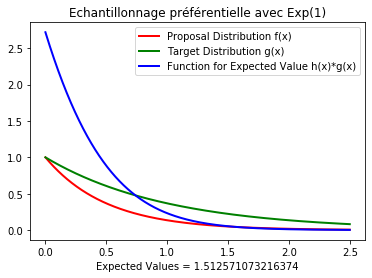

In [165]:
x_values = np.arange(0,2.5,0.001)
y_proposal = np.array(f(x_values))
y_target = np.array(g(x_values))
y_h = np.array(h(x_values)*g(x_values))
plt.plot(x_values,y_proposal, color ='red',linewidth = 2,label = 'Proposal Distribution f(x)')
plt.plot(x_values,y_target, color ='green',linewidth = 2,label = 'Target Distribution g(x)')
plt.plot(x_values,y_h, color ='blue',linewidth = 2,label = 'Function for Expected Value h(x)*g(x)')
plt.title("Echantillonnage préférentielle avec Exp(1)")
plt.xlabel("Expected Values = " + str(expected_val_importance))
plt.legend()
plt.show()

## Part 2 :

## A case study using generated data for MCMC in Bayesian inference

### 1- Generate the Data

10.083007470169607

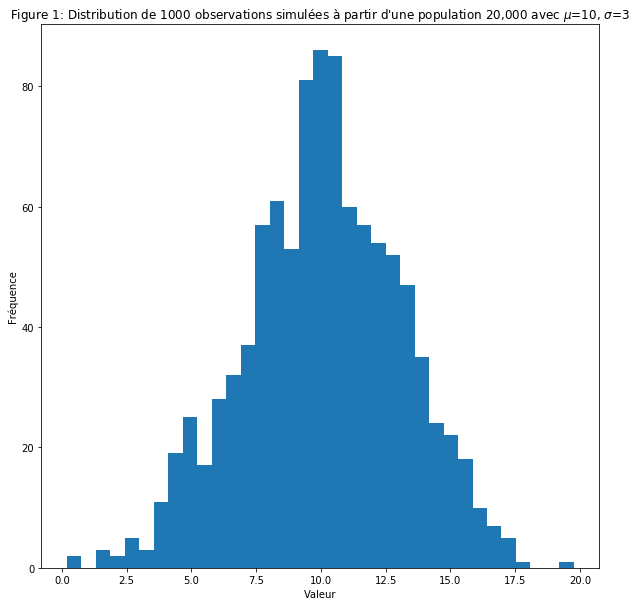

In [188]:
import numpy as np
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
%matplotlib inline
mod1=lambda t:np.random.normal(10,3,t)

#Création d'une population de 30000 individus suivant une loi normale de moyenne=10 et sigma=3 
population = mod1(30000)
#On se restreint à l'observation de 1,000 individus parmis cette population.
observation = population[np.random.randint(0, 30000, 1000)]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation,bins=35 ,)
ax.set_xlabel("Valeur")
ax.set_ylabel("Fréquence")
ax.set_title("Figure 1: Distribution de 1000 observations simulées à partir d'une population 20,000 avec $\mu$=10, $\sigma$=3")
mu_obs=observation.mean()
mu_obs

In [167]:
#le modèle de transition défini comment on passe de sigma_current à sigma_new
transition_model = lambda x: [x[0],np.random.normal(x[1],0.5,(1,))[0]]

def prior(x):
    #x[0] = mu, x[1]=sigma (new ou current)
    #retourne 1 pour le cas d'une valeur valide sigma.
    #retourne 0 dans le cas contraire
    if(x[1] <=0):
        return 0
    return 1

def manual_log_like_normal(x,data):
    #x[0]=mu, x[1]=sigma (new ou current)
    #data = les observations
    return np.sum(-np.log(x[1] * np.sqrt(2* np.pi) )-((data-x[0])**2) / (2*x[1]**2))

def log_lik_normal(x,data):
    return np.sum(np.log(scipy.stats.norm(x[0],x[1]).pdf(data)))


#Détermine soit l'acceptation ou le rejet de notre nouveau échantillon 
def acceptance(x, x_new):
    if x_new>x:
        return True
    else:
        accept=np.random.uniform(0,1)
        # Comme nous avons utilisé la log vraisemblance, on fait appel à l'exponentielle
        return (accept < (np.exp(x_new-x)))


def metropolis_hastings(likelihood_computer,prior, transition_model, param_init,iterations,data,acceptance_rule):
    # transition_model(x): une fonction qui retourne unéchantillon de distribution symétrique
    # param_init: notre échantillon
    # acceptance_rule(x,x_new): decide de oui ou non on accepte ou on rejete le nouveau échantillon
    #iterations=nombre d'acceptation à générer
    x = param_init
    accepted = []
    rejected = []   
    for i in range(iterations):
        x_new =  transition_model(x)    
        x_lik = likelihood_computer(x,data)
        x_new_lik = likelihood_computer(x_new,data) 
        if (acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)            
                
    return np.array(accepted), np.array(rejected)

In [173]:
accepted, rejected = metropolis_hastings(manual_log_like_normal,prior,transition_model,[mu_obs,0.1], 50000,observation,acceptance)

C:\Users\USER INFO\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
C:\Users\USER INFO\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log


In [174]:
accepted[-10:,1]

array([3.00589173, 2.97461399, 2.88014443, 2.89970828, 2.9786153 ,
       3.04732696, 2.8557568 , 2.98016542, 2.95471385, 2.95787088])

In [175]:
print(accepted.shape)

(8167, 2)


(8167, 2)

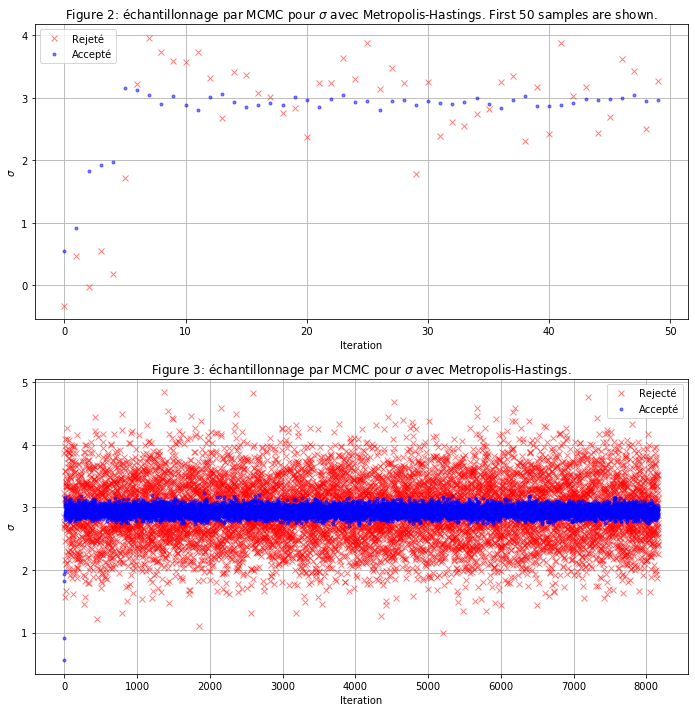

In [185]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2,1,1)

ax.plot( rejected[0:50,1], 'rx', label='Rejeté',alpha=0.5)
ax.plot( accepted[0:50,1], 'b.', label='Accepté',alpha=0.5)
ax.set_xlabel("Iteration")
ax.set_ylabel("$\sigma$")
ax.set_title("Figure 2: échantillonnage par MCMC pour $\sigma$ avec Metropolis-Hastings. First 50 samples are shown.")
ax.grid()
ax.legend()



ax2 = fig.add_subplot(2,1,2)
to_show=-accepted.shape[0]
ax2.plot( rejected[to_show:,1], 'rx', label='Rejecté',alpha=0.5)
ax2.plot( accepted[to_show:,1], 'b.', label='Accepté',alpha=0.5)
ax2.set_xlabel("Iteration")
ax2.set_ylabel("$\sigma$")
ax2.set_title("Figure 3: échantillonnage par MCMC pour $\sigma$ avec Metropolis-Hastings.")
ax2.grid()
ax2.legend()



fig.tight_layout()
accepted.shape

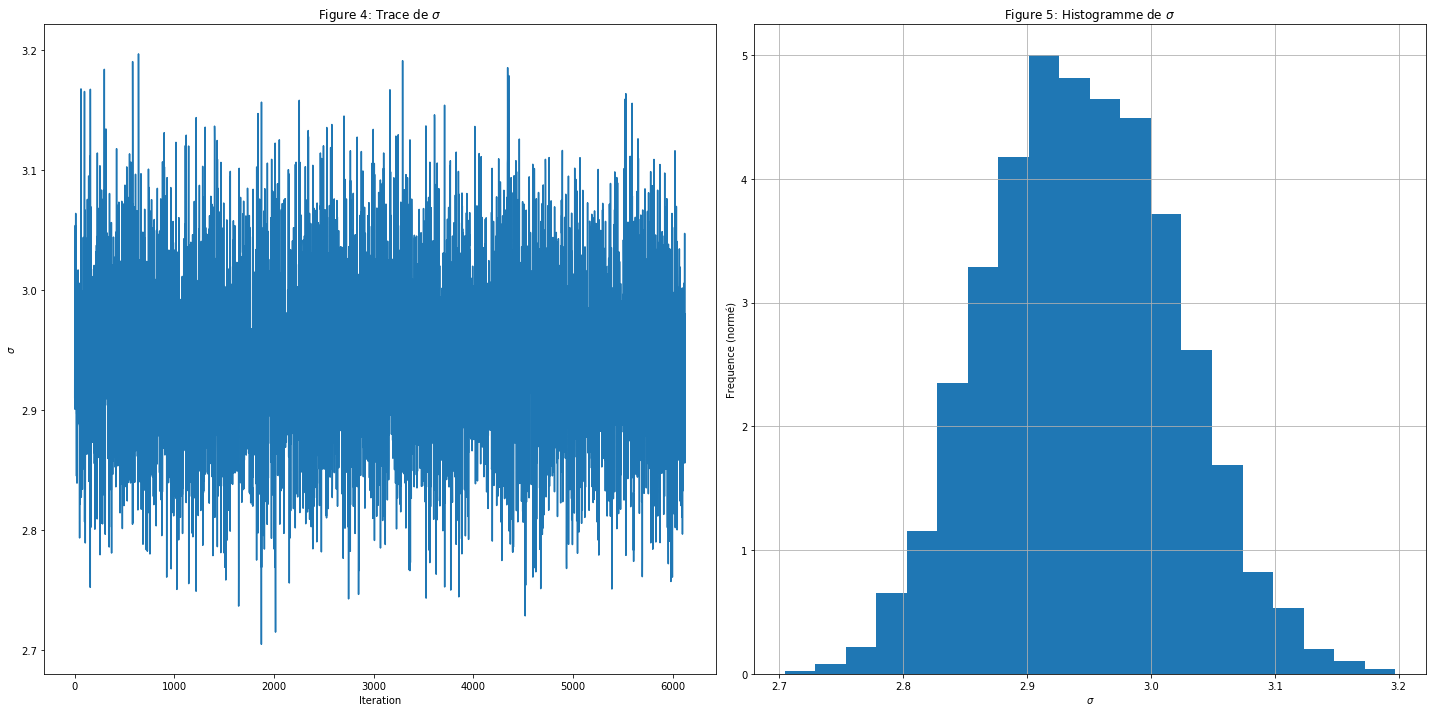

In [189]:
show=int(-0.75*accepted.shape[0])
hist_show=int(-0.75*accepted.shape[0])

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,2,1)
ax.plot(accepted[show:,1])
ax.set_title("Figure 4: Trace de $\sigma$")
ax.set_ylabel("$\sigma$")
ax.set_xlabel("Iteration")
ax = fig.add_subplot(1,2,2)
ax.hist(accepted[hist_show:,1], bins=20,density=True)
ax.set_ylabel("Frequence (normé)")
ax.set_xlabel("$\sigma$")
ax.set_title("Figure 5: Histogramme de $\sigma$")
fig.tight_layout()


ax.grid("off")

9.85068907744751 2.9449042568922463


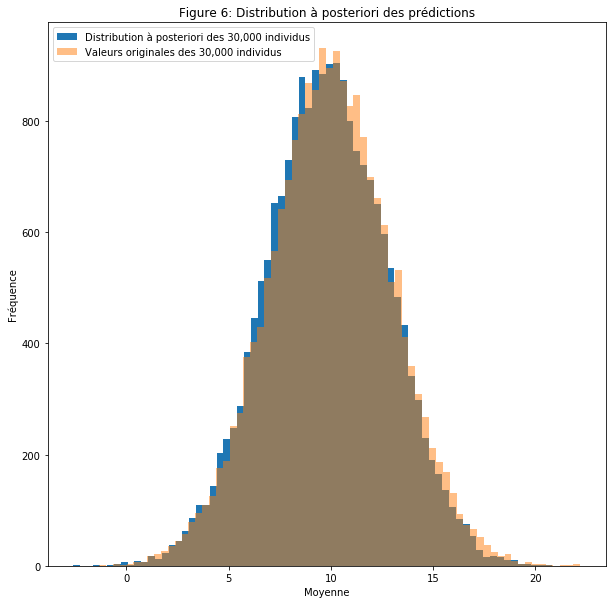

In [184]:
mu=accepted[show:,0].mean()
sigma=accepted[show:,1].mean()
print(mu, sigma)
model = lambda t,mu,sigma:np.random.normal(mu,sigma,t)
observation_gen=model(population.shape[0],mu,sigma)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.hist( observation_gen,bins=70 ,label="Distribution à posteriori des 30,000 individus")
ax.hist( population,bins=70 ,alpha=0.5, label="Valeurs originales des 30,000 individus")
ax.set_xlabel("Moyenne")
ax.set_ylabel("Fréquence")
ax.set_title("Figure 6: Distribution à posteriori des prédictions")
ax.legend()